# This notebook demonstrates how to train buddi4 model from buddi_v2

In [1]:
import sys
import pathlib
import joblib
import subprocess
import re
from collections import defaultdict

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import umap.umap_ as umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from matplotlib_venn import venn2, venn3
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import plot_model

2025-05-12 17:28:31.466403: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 17:28:31.474949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747092511.484278 1195563 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747092511.487129 1195563 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747092511.494939 1195563 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
GENE_ID_COL = 'gene_ids'
TECH_COL = 'samp_type'

## Add buddi_v2 software to path

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)
BUDDI_PATH = REPO_ROOT / "src"

sys.path.insert(0, str(BUDDI_PATH))

from buddi_v2.data import BuDDI4Data
from buddi_v2.dataset.buddi4_dataset import get_supervised_dataset, get_unsupervised_dataset
from buddi_v2.models.buddi4 import build_buddi4, fit_buddi4
from buddi_v2.plotting.plot_latent_space import plot_latent_spaces_buddi4
from buddi_v2.plotting.plot_data import plot_data

I0000 00:00:1747092512.589889 1195563 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


## Pre-Processing Output

In [4]:
## Input data path
DATA_PATH = pathlib.Path('.').absolute() / 'example_data'
assert DATA_PATH.exists()
PREPROCESS_OUTPUT_PATH = pathlib.Path('.').absolute() / 'example_data' / 'preprocessed_data'
assert PREPROCESS_OUTPUT_PATH.exists(), f"Preprocessed data path {PREPROCESS_OUTPUT_PATH} does not exist."

PREPROCESS_SC_AUGMENTED_OUTPUT_PATH = PREPROCESS_OUTPUT_PATH / 'sc_augmented'
assert PREPROCESS_SC_AUGMENTED_OUTPUT_PATH.exists()

CIBERSORTX_SIG_GENE_FILE = DATA_PATH / 'cibersort_liver' /\
    'CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_phenoclasses.CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_refsample.bm.K999.txt'
assert CIBERSORTX_SIG_GENE_FILE.exists()

PREPROCESS_BULK_FORMAT_PATH = PREPROCESS_OUTPUT_PATH / 'bulk_formatted'
assert PREPROCESS_BULK_FORMAT_PATH.exists()

### Load train data

In [5]:
train_data = joblib.load(DATA_PATH / "buddi4_train_data.pkl")
train_data.reset_query()
train_data

BuDDI4Data(total_samples=3649, genes=7000, cell_types=8)

### Supervised vs Unsupervised split & Dataset Generation

In [6]:
(
    X_kp,
    y_kp,
    label_kp,
    stim_kp,
    samp_type_kp,
    meta_kp
) = train_data.query(
    isTraining='Train',
    samp_type='sc_ref'
).get()

(
    X_unkp,
    y_unkp,
    label_unkp,
    stim_unkp,
    samp_type_unkp,
    meta_unkp
) = train_data.query(
    isTraining='Train',
    samp_type='bulk'
).get()

Generating Tensorflow `dataset` objects for BuDDI4 training (**note** `ds_sup` and `ds_unsup` do not work with plotting or model inference out of the box), use raw data (e.g. `X_kp`, `X_unkp`) instead for these purposes.

In [7]:
ds_sup = get_supervised_dataset(
    X_known_prop=X_kp,
    Y_known_prop=y_kp,
    label_known_prop=label_kp,
    stim_known_prop=stim_kp,
    samp_type_known_prop=samp_type_kp,
)
print(f"Number of entries in supervised dataset: {ds_sup.cardinality().numpy()}")
ds_sup_batch_x, ds_sup_batch_y = next(iter(ds_sup))

ds_unsup = get_unsupervised_dataset(
    X_unknown_prop=X_unkp,
    label_unknown_prop=label_unkp,
    stim_unknown_prop=stim_unkp,
    samp_type_unknown_prop=samp_type_unkp,
)
print(f"Number of entries in unsupervised dataset: {ds_unsup.cardinality().numpy()}")

print("\nTake a peek at the dataset generator return:\n")

ds_sup_batch_input, ds_sup_batch_target = next(iter(ds_sup.batch(16).take(1)))
ds_sup_batch_x, ds_sup_batch_y = ds_sup_batch_input
print(f"Supervised batch x shape: {ds_sup_batch_x.shape}")
print(f"Supervised batch y shape: {ds_sup_batch_y.shape}")
ds_sup_batch_target_x, _, _, _, _, ds_sup_batch_label, ds_sup_batch_stim, ds_sup_batch_samp_type, ds_sup_batch_target_y = ds_sup_batch_target
print(f"Supervised batch target x shape: {ds_sup_batch_target_x.shape}")
print(f"Supervised batch target y shape: {ds_sup_batch_target_y.shape}")
print(f"Supervised batch label shape: {ds_sup_batch_label.shape}")
print(f"Supervised batch stim shape: {ds_sup_batch_stim.shape}")
print(f"Supervised batch samp_type shape: {ds_sup_batch_samp_type.shape}")

print("\n")

ds_unsup_batch_input, ds_unsup_batch_target = next(iter(ds_unsup.batch(16).take(1)))
ds_unsup_batch_x, = ds_unsup_batch_input
print(f"Unsupervised batch x shape: {ds_unsup_batch_x.shape}")
ds_unsup_batch_target_x, _, _, _, _, ds_unsup_batch_label, ds_unsup_batch_stim, ds_unsup_batch_samp_type, _ = ds_unsup_batch_target
print(f"Unsupervised batch target x shape: {ds_unsup_batch_target_x.shape}")
print(f"Unsupervised batch label shape: {ds_unsup_batch_label.shape}")
print(f"Unsupervised batch stim shape: {ds_unsup_batch_stim.shape}")
print(f"Unsupervised batch samp_type shape: {ds_unsup_batch_samp_type.shape}")

Number of entries in supervised dataset: 1800
Number of entries in unsupervised dataset: 49

Take a peek at the dataset generator return:

Supervised batch x shape: (16, 7000)
Supervised batch y shape: (16, 8)
Supervised batch target x shape: (16, 7000)
Supervised batch target y shape: (16, 8)
Supervised batch label shape: (16, 51)
Supervised batch stim shape: (16, 2)
Supervised batch samp_type shape: (16, 2)


Unsupervised batch x shape: (16, 7000)
Unsupervised batch target x shape: (16, 7000)
Unsupervised batch label shape: (16, 51)
Unsupervised batch stim shape: (16, 2)
Unsupervised batch samp_type shape: (16, 2)


## BuDDI Training

### Ininstantiate Model

In [8]:
n_x = train_data.nx
n_y = train_data.ny
n_labels = train_data.n_labels
n_stims = train_data.n_stims
n_samp_types = train_data.n_samp_types

In [9]:
from tensorflow.keras.losses import CategoricalCrossentropy, MeanAbsoluteError

CLASSIFIER_ALPHA = 100.0
KL_BETA = 100.0

supervised_buddi, unsupervised_buddi = build_buddi4(
    n_x=n_x,
    n_y=n_y,
    n_labels=n_labels,
    n_stims=n_stims,
    n_samp_types=n_samp_types,

    # Change the reconstruction loss functions here
    reconstr_loss_fn = MeanAbsoluteError, 

    # Change the loss function for all classifies here
    classifier_loss_fn = CategoricalCrossentropy, 
    # Or configure loss functions for each classifier individually
    # if none, uses `classifier_loss_fn`, if specified overrides `classifier_loss_fn`
    label_classifier_loss_fn = None,
    stim_classifier_loss_fn = None,
    samp_type_classifier_loss_fn = None,
    # By default the prop estimator loss is the same as the classifier loss and is set to binary crossentropy.
    # If you find it preferable to frame the proportion estimator as a regression problem, the loss function can be set to
    # MeanSquaredError. 
    prop_estimator_loss_fn = None, 

    # Tune reconstruction loss weights here
    alpha_x = 1.0,

    # Tune classifier loss weights here individually
    alpha_label = CLASSIFIER_ALPHA,
    alpha_stim = CLASSIFIER_ALPHA,
    alpha_samp_type = CLASSIFIER_ALPHA,
    alpha_prop = CLASSIFIER_ALPHA,

    # Tune KL loss weights here individually
    beta_kl_slack = 0.1,
    beta_kl_label = KL_BETA,
    beta_kl_stim = KL_BETA,
    beta_kl_samp_type = KL_BETA,
)

### Visualize Model Architecture

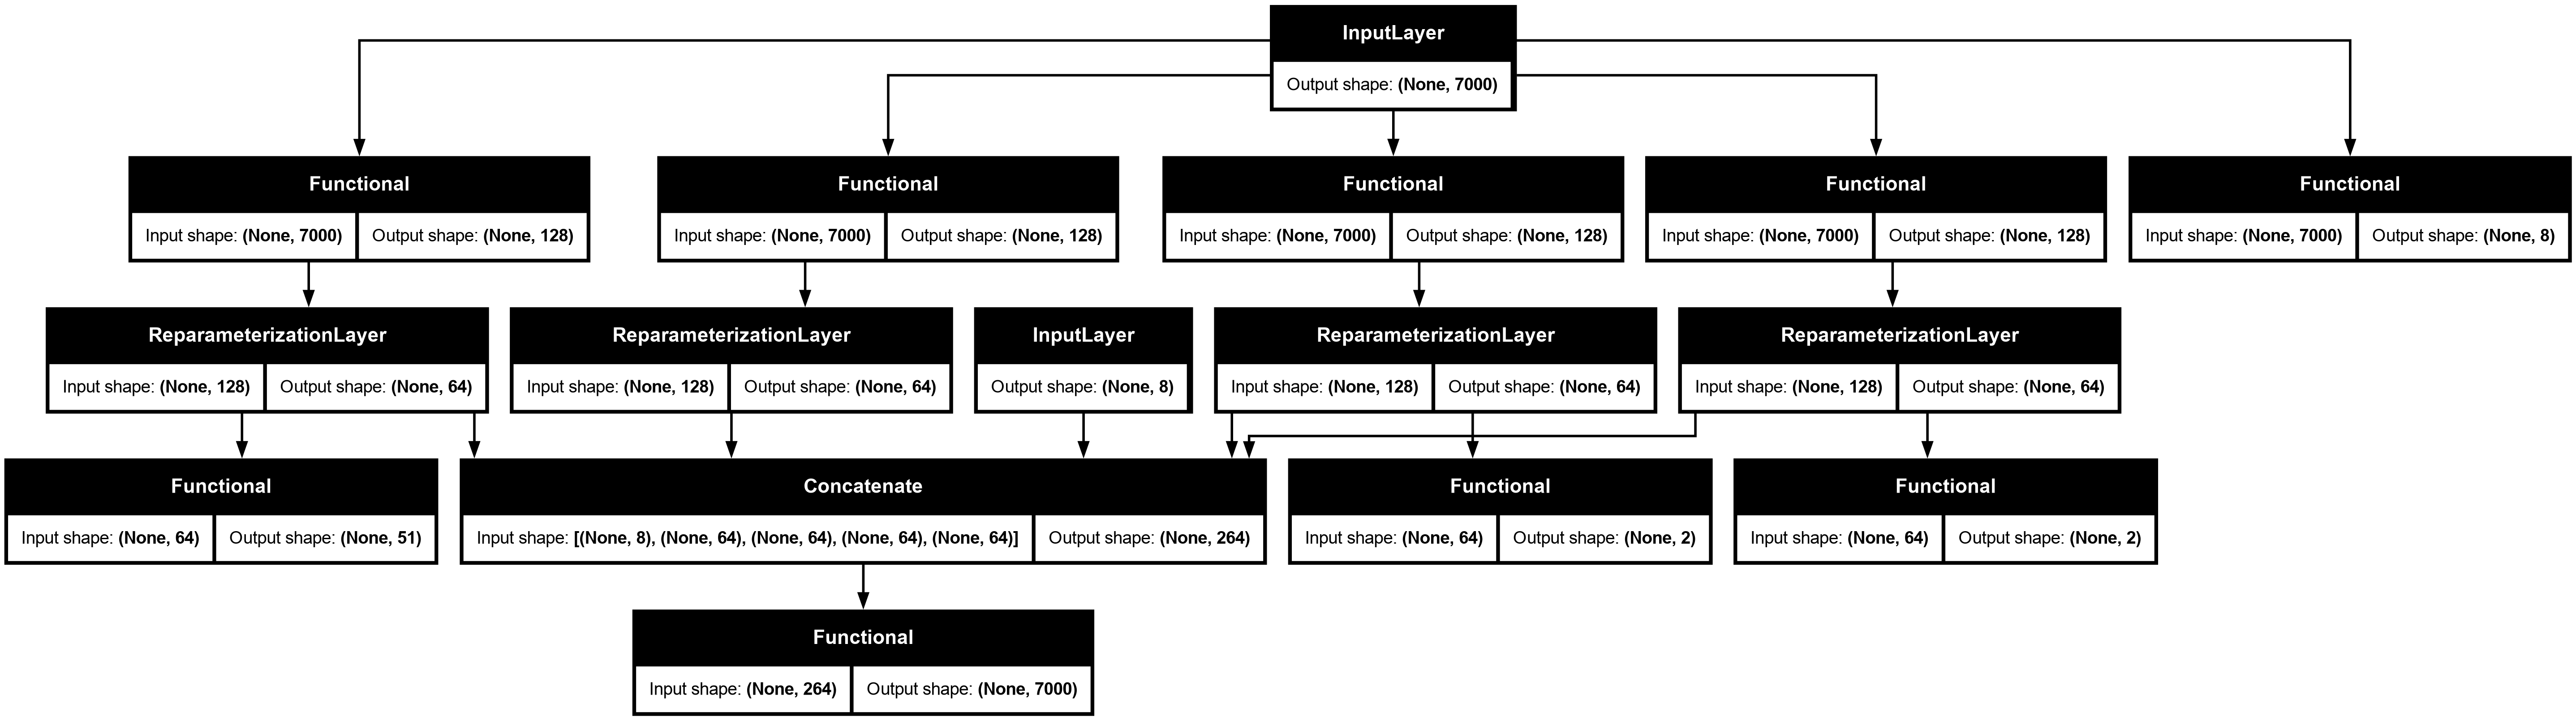

In [10]:
plot_model(supervised_buddi, show_shapes=True)

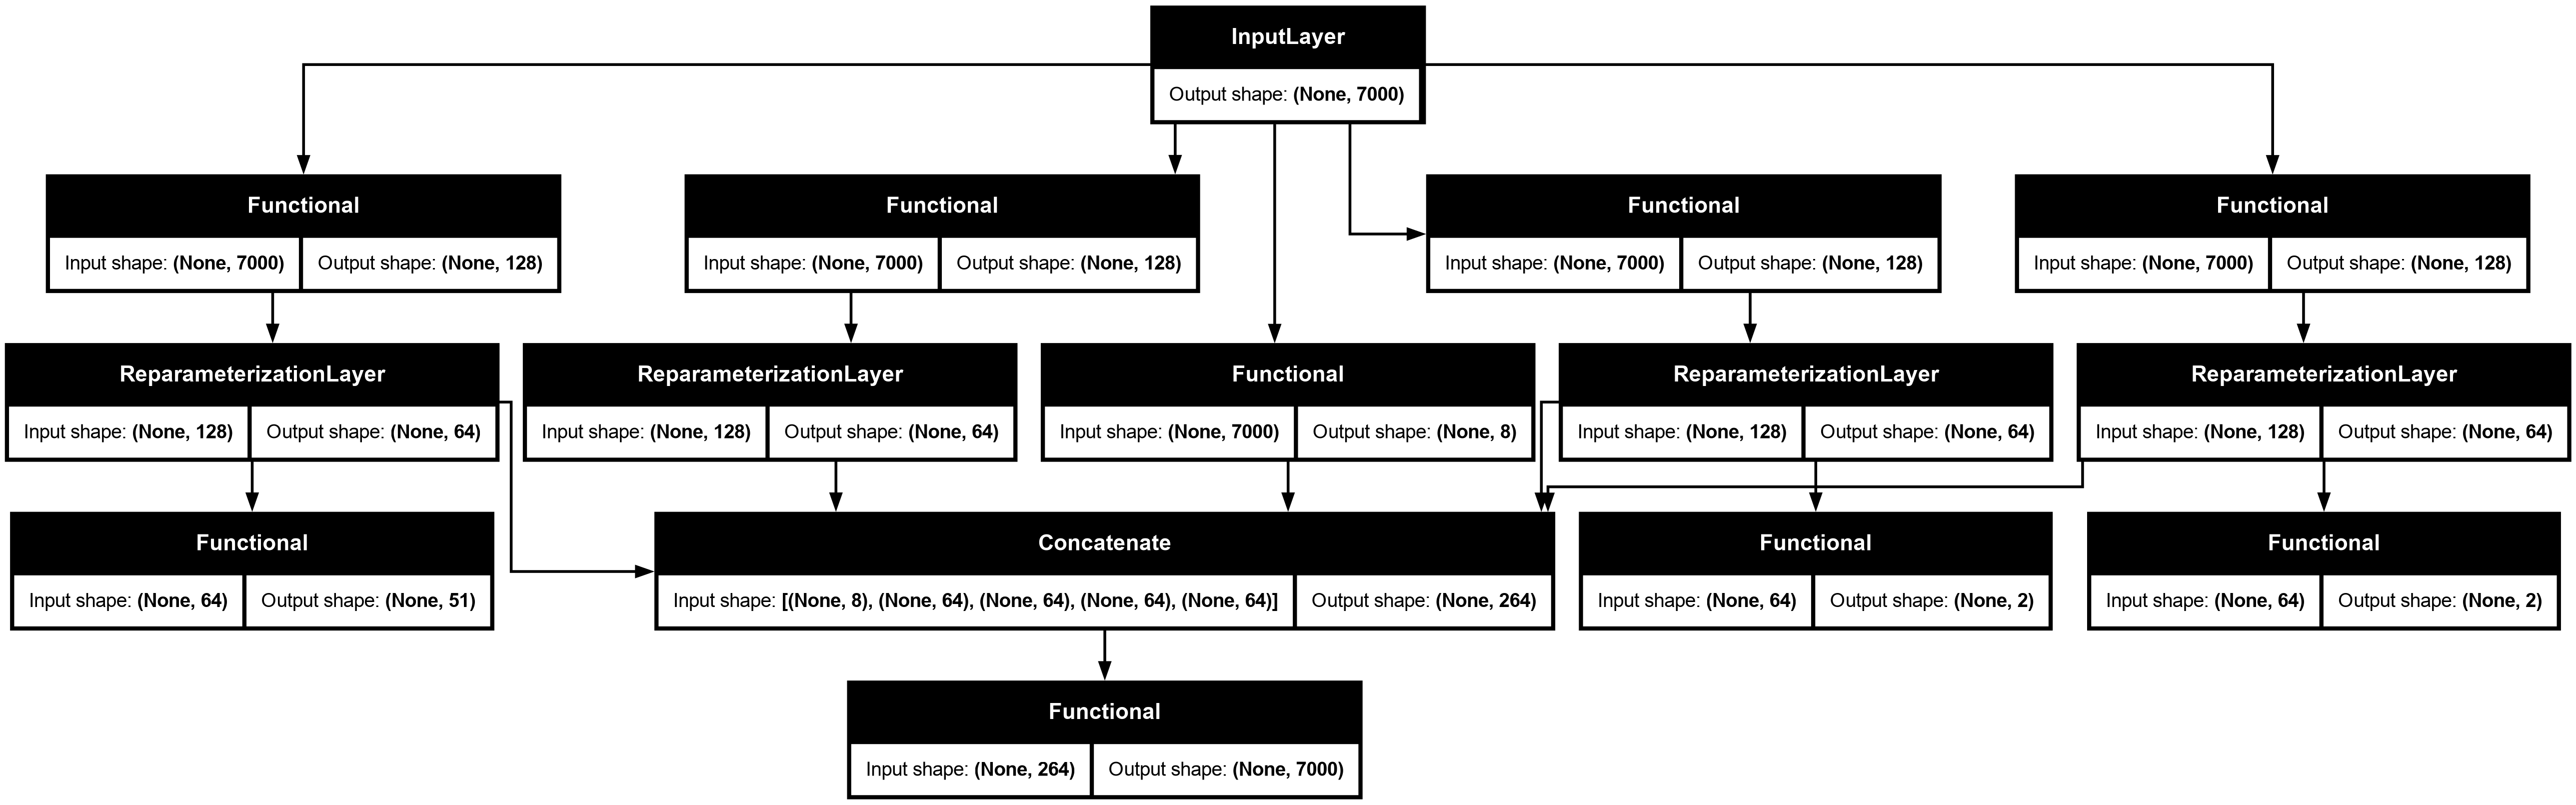

In [11]:
plot_model(unsupervised_buddi, show_shapes=True)

In [12]:
!rm -f model.png

### Train Model

In [13]:
all_loss_df = fit_buddi4(
    supervised_buddi, unsupervised_buddi, 
    ds_sup, ds_unsup, 
    epochs=20, batch_size=16, prefetch=True
)

Epoch 1/20:   0%|          | 0/113 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1747092516.851512 1195563 service.cc:152] XLA service 0x607fe168e3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747092516.851526 1195563 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-05-12 17:28:36.909969: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747092517.270206 1195563 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747092519.094250 1195563 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Epoch 20/20: 100%|██████████| 113/113 [00:06<00:00, 16.81it/s]

Training complete!


### For now the trainer does not autoamtically save model weights, to save, do:

In [14]:
# Save the model
#supervised_buddi.save("supervised_model.h5")
#unsupervised_buddi.save("unsupervised_model.h5")

### Visualize latent space

/home/weishanli/anaconda3/envs/buddi_conda/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['X']
Received: inputs=Tensor(shape=(1000, 7000))
  warnings.warn(msg)


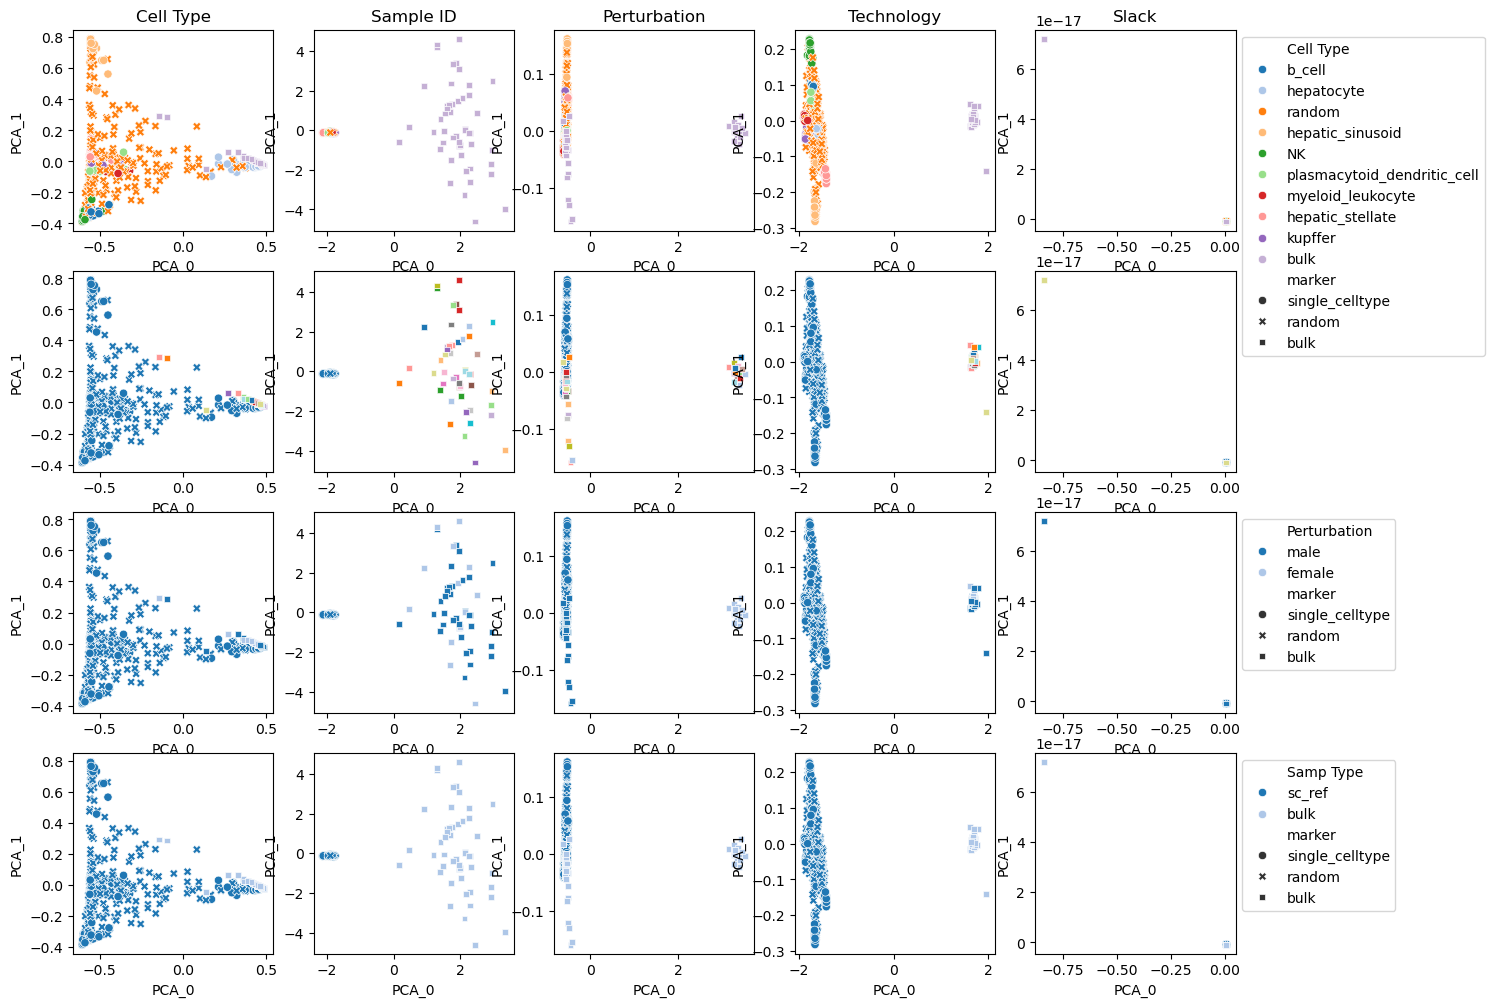

In [ ]:
# Down-sample the sc_ref and bulk data for visualization
(
    X_kp_tmp,
    Y_kp_tmp,
    meta_kp_tmp
) = train_data.query(
    isTraining='Train',
    samp_type='sc_ref'
).get(
    ('X', 'Y', 'meta'),
    n_samples=500,
    replace=True,
    random_state=42
)

(
    X_unkp_tmp,
    Y_unkp_tmp,
    meta_unkp_tmp
) = train_data.query(
    isTraining='Train',
    samp_type='bulk'
).get(
    ('X', 'Y', 'meta'),
    n_samples=500,
    replace=True,
    random_state=42
)

cell_types = train_data.cell_type_names
X_tmp = np.concatenate((X_kp_tmp, X_unkp_tmp), axis=0)
Y_tmp = np.concatenate((Y_kp_tmp, Y_unkp_tmp), axis=0)
meta_tmp = pd.concat((meta_kp_tmp, meta_unkp_tmp), axis=0)


idx_sc_prop = np.where(meta_tmp.cell_prop_type == "single_celltype")[0]
cell_type_labels = [cell_types[i] for i in np.argmax(Y_tmp[idx_sc_prop, :], axis=1)]
cell_type_col = meta_tmp.loc[:,'cell_prop_type'].values.copy()
cell_type_col[idx_sc_prop] = cell_type_labels
meta_tmp.loc[:,'cell_type'] = cell_type_col

_ = plot_latent_spaces_buddi4(
    unsupervised_buddi,
    X_tmp,
    meta_tmp,
    type='PCA',
    alpha=1,    
    panel_width=3,
    show_plot=True,
    save_path=None,
    palette="tab20",
)

### Visualize training losses

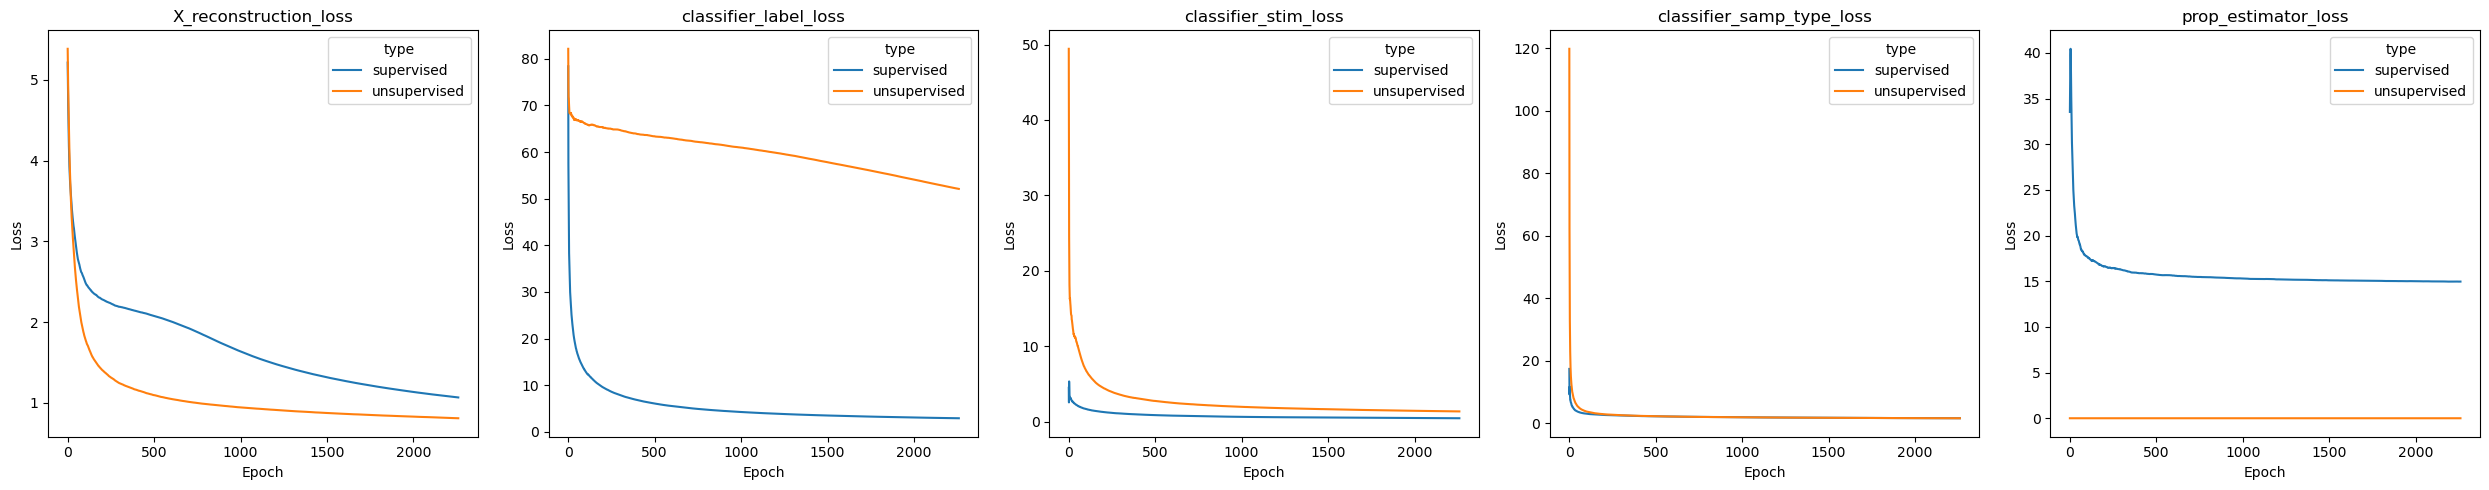

In [16]:
def simple_plot_loss(loss_df, show_plot=True, save_path=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True)

    loss_columns = [
        'X_reconstruction_loss', 
        'classifier_label_loss', 
        'classifier_stim_loss', 
        'classifier_samp_type_loss', 
        'prop_estimator_loss'
    ]

    for ax, col in zip(axes, loss_columns):
        sns.lineplot(
            data=loss_df, 
            x='index', 
            y=col, 
            hue='type', 
            ax=ax
        )
        ax.set_title(col)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    if show_plot:
        plt.show()
    else:
        plt.close()

all_loss_df['index'] = all_loss_df.index.to_list()
simple_plot_loss(all_loss_df, save_path=None, show_plot=True)